In [18]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.optimizers import RMSprop, Adam, adam
from keras.preprocessing.image import ImageDataGenerator

In [19]:
img_rows = 224
img_cols = 224 

In [20]:
#Loads the VGG16 model 
base_conv = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

In [21]:
# Print our layers 
for (i,layer) in enumerate(base_conv.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D True
2 Conv2D True
3 MaxPooling2D True
4 Conv2D True
5 Conv2D True
6 MaxPooling2D True
7 Conv2D True
8 Conv2D True
9 Conv2D True
10 MaxPooling2D True
11 Conv2D True
12 Conv2D True
13 Conv2D True
14 MaxPooling2D True
15 Conv2D True
16 Conv2D True
17 Conv2D True
18 MaxPooling2D True


### Inpsecting each layer

In [22]:
base_conv.summary()
print('No. of hidden layers without extra class number= {}'.format(len(base_conv.layers)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [23]:
def addTopModel(bottom_model):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(4,activation='sigmoid')(top_model)
    return top_model

### Let's add our TL Head back onto VGG

In [24]:
FC_Head = addTopModel(base_conv)

model = Model(inputs=base_conv.input, outputs=FC_Head)

print(model.summary())
print('Number of hidden layer = {}'.format(len(model.layers)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [26]:
nb_train_samples = 96
nb_validation_samples = 32
epochs = 300
batch_size = 16

In [25]:
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_data_dir = "../datasets/split_small_dataset/train/"
val_data_dir = "../datasets/split_small_dataset/val/"
test_data_dir = "../datasets/split_small_dataset/test/"


train_datagen = ImageDataGenerator(rescale = 1./255,
                shear_range = 0.2,
                zoom_range = 0.2,
                horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(train_data_dir,
                                                 target_size = (img_rows, img_cols),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')
val_set = test_datagen.flow_from_directory(val_data_dir,
                                            target_size = (img_rows, img_cols),
                                            batch_size = batch_size,
                                            class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(test_data_dir,
                                            target_size = (img_rows, img_cols),
                                            batch_size = batch_size,
                                            class_mode = 'categorical')

Found 96 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 36 images belonging to 4 classes.


### Trainning Begins

In [28]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
                   
checkpoint = ModelCheckpoint("./saved/small_dataset_vgg.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.1,
                              patience = 3,
                              min_lr=0.00000001,
                              verbose = 1,
                              min_delta = 0.00001)

# we put our call backs into a callback list
callbacks = [checkpoint, earlystop,reduce_lr]

# we use a small learning rate 
model.compile(optimizer=RMSprop(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy','mse','mae','cosine'])


history = model.fit_generator(
    training_set,
    # set steps per epoch equal to the number of training images
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = val_set,
    validation_steps = nb_validation_samples // batch_size)

model.save("./saved/small_dataset_vgg.h5")

Epoch 1/300
6/6 [==============================] - 200s 33s/step - loss: 1.3212 - acc: 0.4167 - mean_squared_error: 0.2137 - mean_absolute_error: 0.4567 - cosine_proximity: -0.5334 - val_loss: 1.1640 - val_acc: 0.5625 - val_mean_squared_error: 0.1630 - val_mean_absolute_error: 0.3863 - val_cosine_proximity: -0.6111

Epoch 00001: val_loss improved from inf to 1.16401, saving model to ./small_dataset_vgg.h5
Epoch 2/300
6/6 [==============================] - 193s 32s/step - loss: 1.0664 - acc: 0.7083 - mean_squared_error: 0.1388 - mean_absolute_error: 0.3298 - cosine_proximity: -0.6639 - val_loss: 0.9087 - val_acc: 0.6875 - val_mean_squared_error: 0.1206 - val_mean_absolute_error: 0.2571 - val_cosine_proximity: -0.7215

Epoch 00002: val_loss improved from 1.16401 to 0.90871, saving model to ./small_dataset_vgg.h5
Epoch 3/300
6/6 [==============================] - 215s 36s/step - loss: 0.9866 - acc: 0.6354 - mean_squared_error: 0.1354 - mean_absolute_error: 0.2539 - cosine_proximity: -0.69

In [36]:
list1 = model.evaluate_generator(test_set, steps=50)

In [41]:
list1

[0.01799761822774982,
 1.0,
 0.07082085019761794,
 0.12081386614590883,
 -0.9992693125417358]

In [45]:
list2 = model.metrics_names
list2

['loss',
 'acc',
 'mean_squared_error',
 'mean_absolute_error',
 'cosine_proximity']

#### Visualization

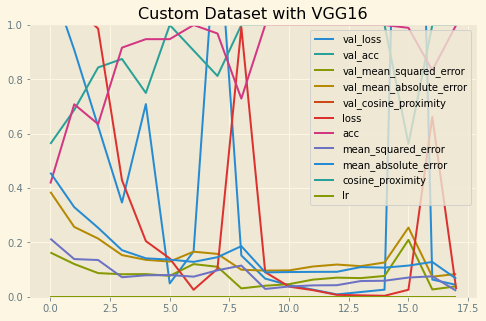

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')
plt.rcParams['figure.figsize'] = [8, 4]

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title('Custom Dataset with VGG16')
plt.show()

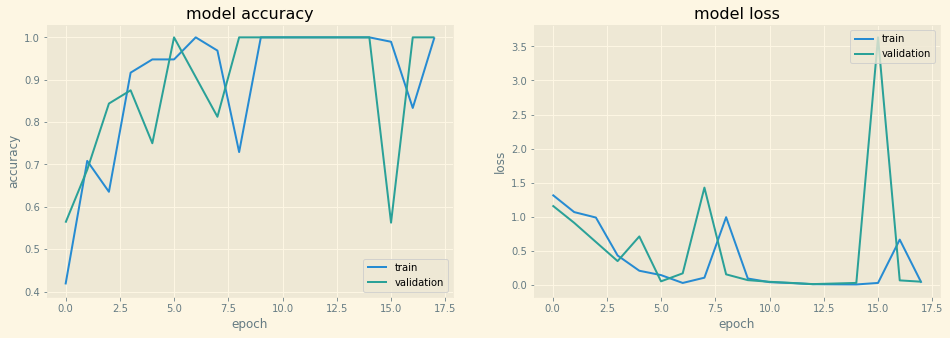

In [30]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

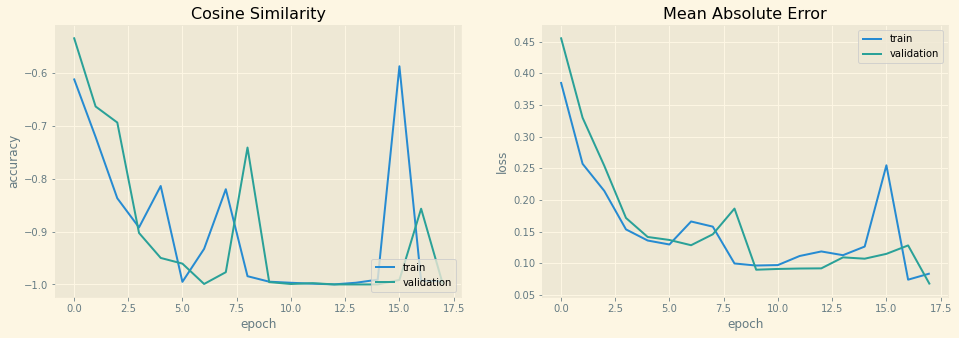

In [31]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(history.history['val_cosine_proximity'])
plt.plot(history.history['cosine_proximity'])
plt.title('Cosine Similarity')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.subplot(122)
plt.plot(history.history['val_mean_absolute_error'])
plt.plot(history.history['mean_absolute_error'])
plt.title('Mean Absolute Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

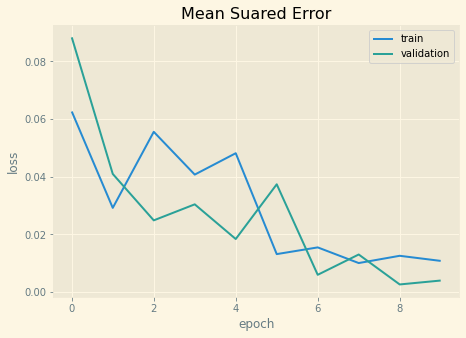

In [14]:
plt.figure(figsize=(16,5))
plt.subplot(122)
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.title('Mean Suared Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

In [ ]:
# %matplotlib inline
# import keras
# from keras.models import Sequential
# from keras.utils.vis_utils import plot_model
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# import numpy as np

# plot_model(model, to_file='mayowa_custom_vgg_bigdataset.png', show_shapes=True, show_layer_names=True)
# img = mpimg.imread('mayowa_custom_vgg_bigdataset.png')
# plt.figure(figsize=(100,70))
# imgplot = plt.imshow(img) 